## Evaluating the impact of earthquakes on people from store purchase history
Magnitude 7.8 earthquake struck Ecuador Muisne on April 16, 2016. Strong tremors were felt even in the capital city of Quito, about 170 km from the epicenter. The damage was widespread, with crudely built structures collapsing hundreds of kilometers from the epicenter. In Guayaquil, the country's largest city, an overpass collapsed on top of a car. In Manta, the control tower at Manta Air Force Base was severely damaged. https://ja.wikipedia.org/wiki/%E3%82%A8%E3%82%AF%E3%82%A2%E3%83%89%E3%83%AB%E5%9C%B0%E9%9C%87_(2016%E5%B9%B4)

Large earthquakes not only scare people, but also make people conservative in their daily lives. They are expected to make a slight change in consumer buying habits.
In this analysis, I evaluate consumer purchasing trends based on correlations between purchase histories for each product in a store in Quito, and analyzes changes in these trends.

<center>
    <table>
        <th>
            <img src="./doc/muisne.png" width="60%", height='60%'>
        </th>
        <th>
            <img src="./doc/earthquake.png" width="60%", height='50%'>
        </th>            
    </table>
</center>

### Data prep & ETL
 - Favorita purchase history data explanation is here https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

In [1]:
%matplotlib inline
import itertools

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import Lasso
from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./data/store_nbr_2_ph.csv')
display(df.head(3))

date  store_nbr  AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  \
0  2013-01-01          2         0.0        0.0     0.0        0.0    0.0   
1  2013-01-02          2         8.0        0.0     3.0     1481.0    0.0   
2  2013-01-03          2         5.0        0.0     2.0     1016.0    0.0   

   BREAD/BAKERY  CELEBRATION  CLEANING  ...  \
0         0.000          0.0       0.0  ...   
1       523.882          0.0    1432.0  ...   
2       321.693          0.0    1398.0  ...   

   holiday_local_Fundacion_de_Santo_Domingo  \
0                                         0   
1                                         0   
2                                         0   

   holiday_local_Independencia_de_Ambato  \
0                                      0   
1                                      0   
2                                      0   

   holiday_local_Independencia_de_Guaranda  \
0                                        0   
1                                        0   
2                                        0   

   holiday_local_Independencia_de_Latacunga  dcoilwtico  year  month  week  \
0                                         0         NaN  2013      1     1   
1                                         0       93.14  2013      1     1   
2                                         0       92.97  2013      1     1   

   quarter  day_of_week  
0        1      Tuesday  
1        1    Wednesday  
2        1     Thursday  

[3 rows x 138 columns]

We focus on the Favorita store in Quito (store number: 2) and analyze how consumers' purchasing habits changed before and after the earthquake by focusing on the change in the partial correlation coefficient.
As I talked in README, I will use and compare the following two methods for calculating the partial correlation coefficient.
1. method for correlating residuals of a linear regression model
2. method using Graphical lasso

#### List of products with purchase history

| | | | | | | |
| -------- | -------- | -------- | -------- | -------- | -------- | -------- |
|AUTOMOTIVE  |BABY CARE  |BEAUTY  |BEVERAGES  |BOOKS  | BREAD/BAKERY  |CELEBRATION  |
|CLEANING  |DAIRY  |DELI  |EGGS  |FROZEN FOODS  |GROCERY I  |GROCERY II  |
|HARDWARE  |HOME AND KITCHEN I  |HOME AND KITCHEN II  |HOME APPLIANCES  |HOME CARE  |LADIESWEAR  |LAWN AND GARDEN |
|LINGERIE  |LIQUOR  |WINE,BEER, MAGAZINES  |MEATS  |PERSONAL CARE  |PET SUPPLIES  |PLAYERS AND ELECTRONICS  |
|POULTRY  |PREPARED FOODS  |PRODUCE  |SCHOOL AND OFFICE SUPPLIES  |SEAFOOD|

ttl: 33 products

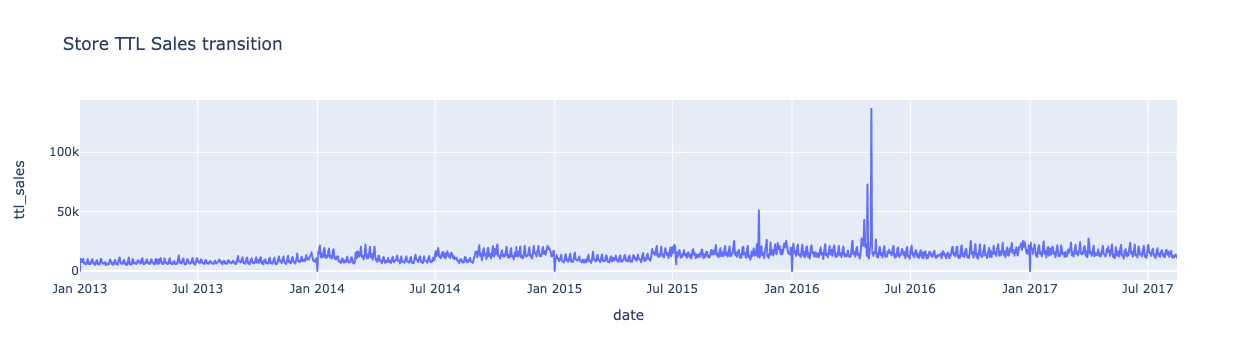

In [3]:
fig = px.line(df, x='date', y='ttl_sales', title="Store TTL Sales transition")
fig.show()

The impact of earthquake can be seen from store sales.

### INDIRECT correlation matrix and PARTIAL (or DIRECT) correlation matrix

#### INDIRECT correlation 
 - INDIRECT correlation matrix is simply calculated by pandas.DataFrame.corr() function.

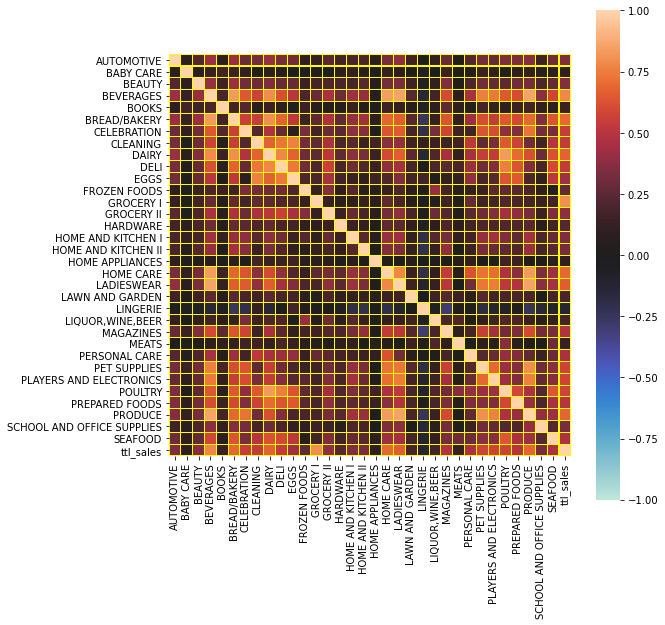

In [4]:
product_list = [
 'AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION',
 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN',
 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD', 'ttl_sales'
]
df_normalized = StandardScaler().fit_transform(df[product_list])
df_normalized = pd.DataFrame(df_normalized, index=df.index, columns=product_list)
df_corr_indirect = df_normalized.corr()

plt.figure(figsize=(9,9))
sns.heatmap(df_corr_indirect, square=True, center=0, linewidths=0.05, linecolor='yellow',vmin=-1, vmax=1)
plt.show()

#### PARTIAL correlation
1. Confirm multivariate normality and perform Graphical Lasso model.
 - Confirm multivariate normality --> Appendix
2. Pick up some product pair and caluculate PARTIAL correlation by building linear regression model.

Pick up product pair example
INDIRECT correlation between BREAD/BAKERY and BEVERAGES: 0.8288586618099218
PARTIAL correlation between BREAD/BAKERY and BEVERAGES: 0.4288485919584675


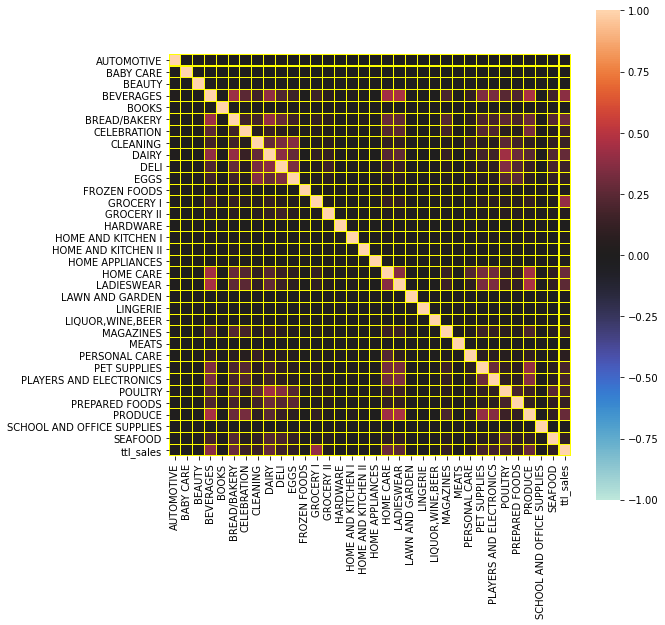

In [5]:
model = GraphicalLasso(alpha=0.4,verbose=False)
model.fit(df_normalized)
partial_correlation_matrix = model.covariance_
# pre_zero=partial_correlation_matrix-np.diag(np.diag(partial_correlation_matrix))
df_corr_partial = pd.DataFrame(index=df_normalized.columns,
                     columns=df_normalized.columns, 
                     data=partial_correlation_matrix.tolist())
plt.figure(figsize=(9,9))
sns.heatmap(df_corr_partial, square=True, center=0, linewidths=0.05, linecolor='yellow',vmin=-1, vmax=1)
print('Pick up product pair example')
print('INDIRECT correlation between BREAD/BAKERY and BEVERAGES: {}'.format(df_corr_indirect.loc['BREAD/BAKERY', 'BEVERAGES']))
print('PARTIAL correlation between BREAD/BAKERY and BEVERAGES: {}'.format(df_corr_partial.loc['BREAD/BAKERY', 'BEVERAGES']))

Pick up BREAD/BAKERY and BEVERAGES product pair and calculate partial correlation by building linear regression model.
$$
residual\_bread\_bakery = Sales\ of\ BREAD\ /\ BAKERY\ -\ LinearRegression() \\
residual\_bread\_beverages = Sales\ of\ BEVERAGES\ -\ LinearRegression() \\
partial\_correlation(BREAD\ /\ BAKERY, BEVERAGES) = corr(residual\_bread\_bakery, residual\_bread\_beverages)
$$

In [6]:
bread_bakery_explanatory = list(set(product_list) - set(['BREAD/BAKERY', 'BEVERAGES', 'ttl_sales']))
beverages_explanatory = list(set(product_list) - set(['BREAD/BAKERY', 'BEVERAGES', 'ttl_sales']))

bread_bakery_model = Lasso(alpha=0.2)
bread_bakery_model.fit(df_normalized[bread_bakery_explanatory], df_normalized['BREAD/BAKERY'])

beverages_model = Lasso(alpha=0.2)
beverages_model.fit(df_normalized[beverages_explanatory], df_normalized['BEVERAGES'])

df_normalized['pred_bread_bakery'] = bread_bakery_model.predict(df_normalized[bread_bakery_explanatory])
df_normalized['pred_beverages'] = beverages_model.predict(df_normalized[beverages_explanatory])
df_normalized['residual_bread_bakery'] = df_normalized['BREAD/BAKERY'] - bread_bakery_model.predict(df_normalized[bread_bakery_explanatory])
df_normalized['residual_beverages'] = df_normalized['BEVERAGES'] - beverages_model.predict(df_normalized[beverages_explanatory])

df_normalized[['BREAD/BAKERY', 'BEVERAGES', 
               'pred_bread_bakery', 'pred_beverages',
               'residual_bread_bakery', 'residual_beverages']].corr()

BREAD/BAKERY  BEVERAGES  pred_bread_bakery  \
BREAD/BAKERY               1.000000   0.828859           0.883027   
BEVERAGES                  0.828859   1.000000           0.900651   
pred_bread_bakery          0.883027   0.900651           1.000000   
pred_beverages             0.808536   0.941837           0.923651   
residual_bread_bakery      0.825051   0.480682           0.463349   
residual_beverages         0.617612   0.804585           0.591445   

                       pred_beverages  residual_bread_bakery  \
BREAD/BAKERY                 0.808536               0.825051   
BEVERAGES                    0.941837               0.480682   
pred_bread_bakery            0.923651               0.463349   
pred_beverages               1.000000               0.414616   
residual_bread_bakery        0.414616               1.000000   
residual_beverages           0.558216               0.454086   

                       residual_beverages  
BREAD/BAKERY                     0.617612  
BEVERAGES                        0.804585  
pred_bread_bakery                0.591445  
pred_beverages                   0.558216  
residual_bread_bakery            0.454086  
residual_beverages               1.000000

Partial correlation between BREAD/BAKERY and BEVERAGES is 
 - Graphical Lasso: 0.43
 - Linear regression residual: 0.45

The coefficients are slightly different depending on the value of the alpha parameter of Lasso, but the values are generally close.

### Consumer buying habits change
By focusing on the time-series changes in the partial correlation coefficients between products, we can evaluate the changes in consumers' purchasing tendencies.
<img src="./doc/corr_history_mechanism2.png" height='80%'>

The window is shifted in 30-day steps over a 180-day period, and the partial correlation coefficient between product pairs is calculated using Graphical Lasso based on the purchase history of the window period. If there is an effect of the earthquake, there must be some change in the correlation between products, so we observe the change by representing the correlation between products in a time series graph.

In [7]:
df_normalized['date'] = df['date']
df_normalized['date'] = pd.to_datetime(df_normalized['date'])

def get_partial_corr(dftmp):
    # Remove non-selling product
    nunique = dftmp.nunique()
    cols_to_drop = nunique[nunique == 1].index
    dftmp = dftmp.drop(cols_to_drop, axis=1)
    dftmp_bk = dftmp.copy()
    dftmp = StandardScaler().fit_transform(dftmp)
    dftmp = pd.DataFrame(dftmp, index=dftmp_bk.index, columns=dftmp_bk.columns)
    model = GraphicalLasso(alpha=0.4,verbose=False)
    model.fit(dftmp)
    partial_correlation_matrix = model.covariance_
    df_corr_partial = pd.DataFrame(index=dftmp.columns,
                         columns=dftmp.columns, 
                         data=partial_correlation_matrix.tolist())
    return df_corr_partial

front = 0
end = 180
step = 30

partial_corr_matrix_list = []
date_list = []

while end < len(df_normalized):
    df_normalized_part = df_normalized[front:end]
    partial_corr_matrix_list.append(get_partial_corr(df_normalized_part[product_list]))
    date_list.append(df_normalized_part['date'].max())
    front += step
    end = front + 180
corr_history = {}

def get_pair_partial_corr(pair, df_partial_corr_matrix):
    if pair[0] not in df_partial_corr_matrix.columns or pair[1] not in df_partial_corr_matrix.columns:
        return 0
    return df_partial_corr_matrix.loc[pair[0], pair[1]]
    
for pair in itertools.combinations(product_list, 2):
    corr_history[pair[0] + '--' + pair[1]] = []
    
for df_partial_corr_matrix in partial_corr_matrix_list:
    for pair in itertools.combinations(product_list, 2):
        corr_history[pair[0] + '--' + pair[1]].append(get_pair_partial_corr(pair, df_partial_corr_matrix))
        
df_corr_history = pd.DataFrame(
    index=date_list,
    columns=list(corr_history.keys())
)
for col in df_corr_history.columns:
    df_corr_history[col] = corr_history[col]
df_corr_history['date'] = df_corr_history.index

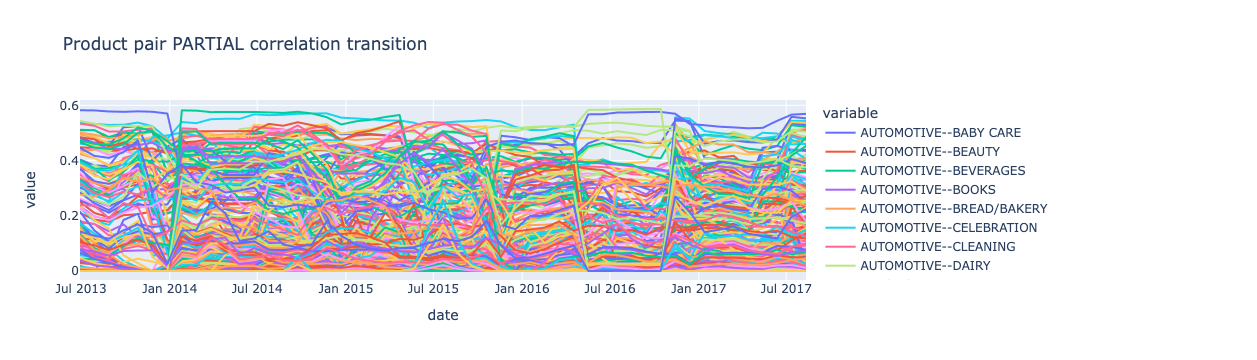

In [8]:
fig = px.line(df_corr_history, x='date', y=df_corr_history.columns, title="Product pair PARTIAL correlation transition")
fig.show()

Pick up some product pair

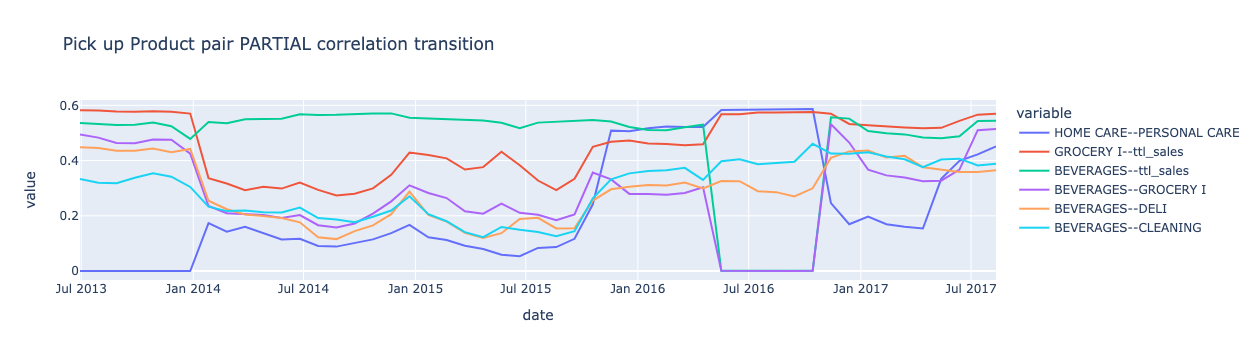

In [9]:
pick_up_pairs = ['HOME CARE--PERSONAL CARE', 'GROCERY I--ttl_sales', 'BEVERAGES--ttl_sales', 'BEVERAGES--GROCERY I', 'BEVERAGES--DELI', 'BEVERAGES--CLEANING']
fig = px.line(df_corr_history, x='date', y=pick_up_pairs, title="Pick up Product pair PARTIAL correlation transition")
fig.show()

It is clear that the partial correlations between product pair changed dramatically before and after the earthquake. In particular, the following product pairs show significant changes.
- PARTIAL correlation between BEVERAGES and ttl_saes, GROCERY I is dramatically changed(declined) due to earthquake (note: happened at 2016.4)
- PARTIAL correlation between HOME CARE and PERSONAL CARE is increased due to earthquake, but the partial correlation between the two had been rising since the fall of 2015.
- After earthquake, PARTIAL correlation between HOME CARE and PERSONAL CARE declined significantly, but it turns out to be increasing trend from 2017.4
- PARTIAL correlation between GROCERY I and ttl_sales is increased due to earthquake and remained high in 2017.

## Conclusion
 - add some conclusion here.

In [10]:
df_corr_history.to_csv('df_corr_history.csv', index=False)